<h1>Deep Learning</h1>
<h2>Assignment 1</h2><br/>
The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the <a href='http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html'>notMNIST </a> dataset to be used with python experiments. This dataset is designed to look like the classic MNIST dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.



In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.

import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import glob
import random
import hashlib
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

('Found and verified', './notMNIST_large.tar.gz')
('Found and verified', './notMNIST_small.tar.gz')


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


<h1>Problem 1 </h1><br>
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

In [4]:
#trying to check number of images in each class and displaying an image of each class
list_of_images = []
for i in train_folders:
    img_list = glob.glob(i+"/"+"*.png")
    print(len(img_list))
    img_name = img_list[10]
    list_of_images.append(img_name)

for i in list_of_images:
    display(Image(i))

52912
52912
52912
52912
52912
52912
52912
52912
52912
52911


In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

<h1> Problem 2 </h1><br>
Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.



In [6]:
print train_datasets

['./notMNIST_large/A.pickle', './notMNIST_large/B.pickle', './notMNIST_large/C.pickle', './notMNIST_large/D.pickle', './notMNIST_large/E.pickle', './notMNIST_large/F.pickle', './notMNIST_large/G.pickle', './notMNIST_large/H.pickle', './notMNIST_large/I.pickle', './notMNIST_large/J.pickle']


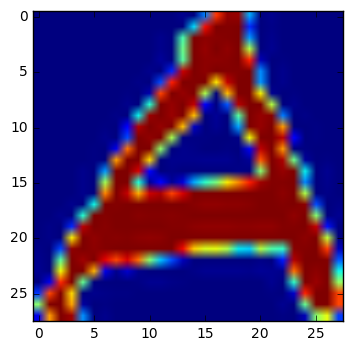

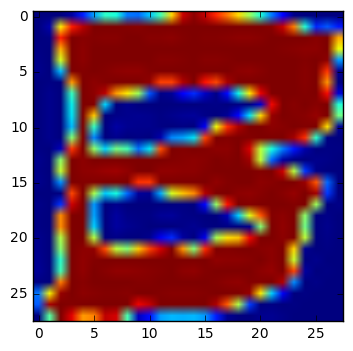

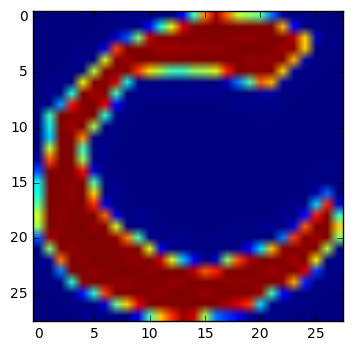

In [7]:
for pickle_file in train_datasets[0:3]:
    letter_full_data = pickle.load(open(pickle_file,'rb'))
    letter = letter_full_data[1]
    plt.figure()
    plt.imshow(letter)

<h1>Problem 3</h1><br/>
Another check: we expect the data to be balanced across classes. Verify that.

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [8]:
print "Train dataset"
for pickle_file in train_datasets:
    letter_full_data = pickle.load(open(pickle_file,'rb'))
    print "Letter "+ os.path.basename(pickle_file).split(".")[0] + " has " + str(letter_full_data.shape[0]) + " images"

print ""

print "Test dataset"
for pickle_file in test_datasets:
    letter_full_data = pickle.load(open(pickle_file,'rb'))
    print "Letter "+ os.path.basename(pickle_file).split(".")[0] + " has " + str(letter_full_data.shape[0]) + " images"

Train dataset
Letter A has 52909 images
Letter B has 52911 images
Letter C has 52912 images
Letter D has 52911 images
Letter E has 52912 images
Letter F has 52912 images
Letter G has 52912 images
Letter H has 52912 images
Letter I has 52912 images
Letter J has 52911 images

Test dataset
Letter A has 1872 images
Letter B has 1873 images
Letter C has 1873 images
Letter D has 1873 images
Letter E has 1873 images
Letter F has 1872 images
Letter G has 1872 images
Letter H has 1872 images
Letter I has 1872 images
Letter J has 1872 images


In [9]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)


('Training:', (200000, 28, 28), (200000,))
('Validation:', (10000, 28, 28), (10000,))
('Testing:', (10000, 28, 28), (10000,))


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [10]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

<h1>Problem 4</h1><br/>
Convince yourself that the data is still good after shuffling!

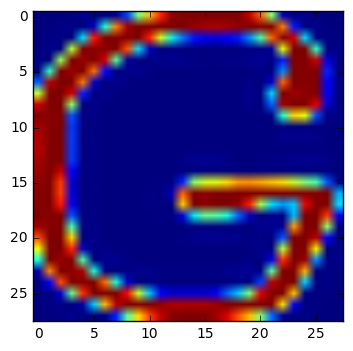

In [11]:
plt.imshow(train_dataset[11]) #Displaying one of the letters

Finally, let's save the data for later reuse:

In [12]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

<h1>Problem 5 </h1><br/>
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.


In the below block we have removed all possible duplicate images within each type of dataset itself.

In [13]:
all_data = pickle.load(open('notMNIST.pickle', 'rb'))

train_dataset = all_data['train_dataset']
test_dataset = all_data['test_dataset']
valid_dataset = all_data['valid_dataset']

train_labels = all_data['train_labels']
test_labels = all_data['test_labels']
valid_labels = all_data['valid_labels']

# Using unique method of numpy to find unique images in the dataset
# using indices for makign sure that the dataset and labels are in sync
u,indices = np.unique(train_dataset,return_index =True,axis = 0)
print "unique images in train dataset:",len(indices)
print "shape of unique image tensor for train is now:",u.shape
print "duplicates in train dataset",train_dataset.shape[0]-len(indices)
print ""
train_dataset = u
train_labels = train_labels[indices]

u,indices = np.unique(test_dataset,return_index=True,axis = 0)
print "unique images in test dataset:",len(indices)
print "shape of unique image tensor for test is now:",u.shape
print "duplicates in test dataset",test_dataset.shape[0]-len(indices)
print ""
test_dataset = u
test_labels = test_labels[indices]

u,indices = np.unique(valid_dataset,return_index =True,axis = 0)
print "unique images in validation dataset:",len(indices)
print "shape of unique image tensor for valid is now is:",u.shape
print "duplicates in validation dataset",valid_dataset.shape[0]-len(indices)
valid_dataset = u
valid_labels = valid_labels[indices]

unique images in train dataset: 187318
shape of unique image tensor for train is now: (187318, 28, 28)
duplicates in train dataset 12682

unique images in test dataset: 9823
shape of unique image tensor for test is now: (9823, 28, 28)
duplicates in test dataset 177

unique images in validation dataset: 9860
shape of unique image tensor for valid is now is: (9860, 28, 28)
duplicates in validation dataset 140


Removing duplicates of valid and test dataset which are present in train dataset. We will train the model on train dataset and having duplicates of train dataset available in test and valid dataset can result in getting wrong test and validation accuracy. The accuracy can give a wrong indication of our models performing well.

In [15]:
def remove_duplicates(dataset1, dataset2, dataset1_labels):

    """
    
    dataset1: From this dataset duplicates would be removed
    dataset2: This dataset would be used a reference to be compared and no data would be removed from here
    
    """
    
    combined_dataset = np.vstack((dataset2,dataset1))
    u,indices = np.unique(combined_dataset,return_index =True,axis = 0)
    
    indices_unique_for_dataset2 = indices[indices>=dataset2.shape[0]]
    actual_unique_indices = indices_unique_for_dataset2 - dataset2.shape[0]
    
    return dataset1[actual_unique_indices],dataset1_labels[actual_unique_indices]

valid_dataset_size_before = valid_dataset.shape[0]
valid_dataset,valid_labels = remove_duplicates(valid_dataset, train_dataset, valid_labels)
print "number of duplicates when compared to train dataset:", valid_dataset_size_before - valid_dataset.shape[0]
print "number of images left in valid dataset:",valid_dataset.shape[0]
print ""

test_dataset_size_before = test_dataset.shape[0]
test_dataset,test_labels = remove_duplicates(test_dataset, train_dataset, test_labels)
print "number of duplicates when compared to train dataset:", test_dataset_size_before - test_dataset.shape[0]
print "number of images left in valid dataset:",test_dataset.shape[0]


number of duplicates when compared to train dataset: 942
number of images left in valid dataset: 8918

number of duplicates when compared to train dataset: 1116
number of images left in valid dataset: 8707


label 9
label 9
label 6


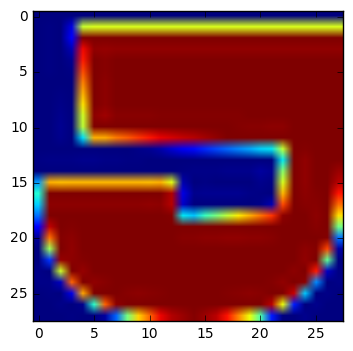

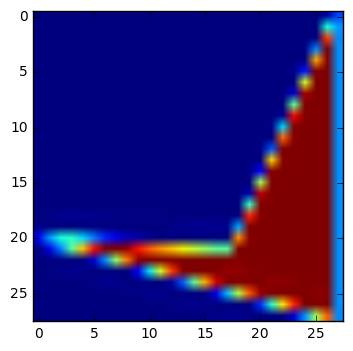

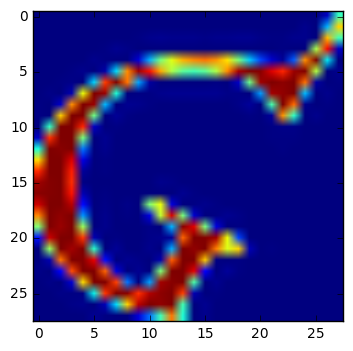

In [20]:
for img,label in zip(test_dataset[1:4],test_labels[1:4]):
    
    plt.figure()
    print "label",label
    plt.imshow(img)

In [21]:
print "train dataset shape now:",train_dataset.shape
print "train labels shape:",train_labels.shape

print "test_dataset shape now:",test_dataset.shape
print "test labels shape:",test_labels.shape

print "validation dataset shape now:",valid_dataset.shape
print "validation labels shape:",valid_labels.shape

train dataset shape now: (187318, 28, 28)
train labels shape: (187318,)
test_dataset shape now: (8707, 28, 28)
test labels shape: (8707,)
validation dataset shape now: (8918, 28, 28)
validation labels shape: (8918,)


unique method of numpy actually sorts the list of image array and thus the images form a patter which the model can learn and can give poor results and will not generalize

In [22]:
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [23]:
pickle_file = os.path.join(data_root, 'notMNIST_clean.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

<h1>Problem 6</h1><br/>
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

In [24]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import time

Taking all the data for training

In [25]:
logistic = linear_model.LogisticRegression()
train_dataset = train_dataset.reshape(train_dataset.shape[0],-1)
print (train_dataset.shape)

test_dataset = test_dataset.reshape(test_dataset.shape[0],-1)

t0 = time.time()
logistic.fit(train_dataset[0:1000],train_labels[0:1000])
print ("time required for training:", time.time()-t0)



(187318, 784)
('time required for training:', 2.958636999130249)


Testing the model on test data

In [26]:
print "test accuracy for the model:",logistic.score(test_dataset, test_labels)

test accuracy for the model: 0.808774549213


In [27]:
all_data = pickle.load(open('notMNIST.pickle', 'rb'))

train_dataset = all_data['train_dataset']
test_dataset = all_data['test_dataset']
valid_dataset = all_data['valid_dataset']

train_labels = all_data['train_labels']
test_labels = all_data['test_labels']
valid_labels = all_data['valid_labels']

In [28]:
logistic = linear_model.LogisticRegression()
train_dataset = train_dataset.reshape(train_dataset.shape[0],-1)
print (train_dataset.shape)

test_dataset = test_dataset.reshape(test_dataset.shape[0],-1)

t0 = time.time()
logistic.fit(train_dataset[0:1000],train_labels[0:1000])
print ("time required for training:", time.time()-t0)

(200000, 784)
('time required for training:', 3.137573003768921)


Test accuracy is high when taking same number of images for training from the data having duplicates, it could be because of the same set of images present in test data, which increases the accuracy of the model in thiscase.

In [29]:
print "test accuracy for the model:",logistic.score(test_dataset, test_labels)

test accuracy for the model: 0.8327
